In [24]:
# transform dataset using n_comps = 3
pca = PCA(n_components=3).fit(Xtr)
x = pca.transform(Xtr)

In [25]:
pca3 = pd.DataFrame(pca.components_, columns=data_scaled.columns, index=['PC-1','PC-2','PC-3']).T
pca3

,PC-1,PC-2,PC-3
danceability,-0.164489,-0.766859,-0.211481
energy,-0.522465,0.244085,-0.135654
acousticness,0.445688,-0.268657,0.298748
valence,-0.393544,-0.475016,-0.117408
pitch_med,-0.485263,0.208217,-0.038967
timbre_med,-0.333135,-0.105732,0.912316


### Perform clustering on scaled features Xtr

determine the optimum value of K for clustering

In [26]:
from sklearn.cluster import KMeans

In [27]:
def test(data, nClusterRange):
    inertias = np.zeros(len(nClusterRange))
    for i in range(len(nClusterRange)):
        model = KMeans(n_clusters=i+1, init='k-means++').fit(data)
        inertias[i] = model.inertia_
    return inertias

In [28]:
import numpy as np
kRange = range(1,12)
KmeanTopics = test(Xtr, kRange)

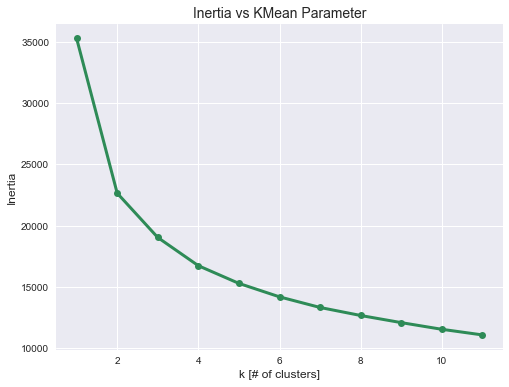

In [29]:
figInertiaWithK = plt.figure(figsize=(8,6))

plt.plot(kRange, KmeanTopics, 'o-', color='seagreen', linewidth=3)
plt.xlabel('k [# of clusters]', size=12)
plt.ylabel('Inertia', size=12)
plt.title('Inertia vs KMean Parameter', size=14)



Let us apply KMeans clustering algorithms using the transformed features and see what patterns/clusters this gives us. 

## KMeans clustering (K = 3) using Scaled features Xtr

In [30]:
km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(Xtr)
cluster_labels = km.labels_
songsDF['K_cluster_n3'] = cluster_labels

In [31]:
songsDF['pca1'] = x[:,0]
songsDF['pca2'] = x[:,1]
songsDF['pca3'] = x[:,2]


In [32]:
c1 = songsDF[songsDF.K_cluster_n3 == 0]
c2 = songsDF[songsDF.K_cluster_n3 == 1]
c3 = songsDF[songsDF.K_cluster_n3 == 2]


### Plotting first 3 components from transformed dataset to visualize the resulting clusters

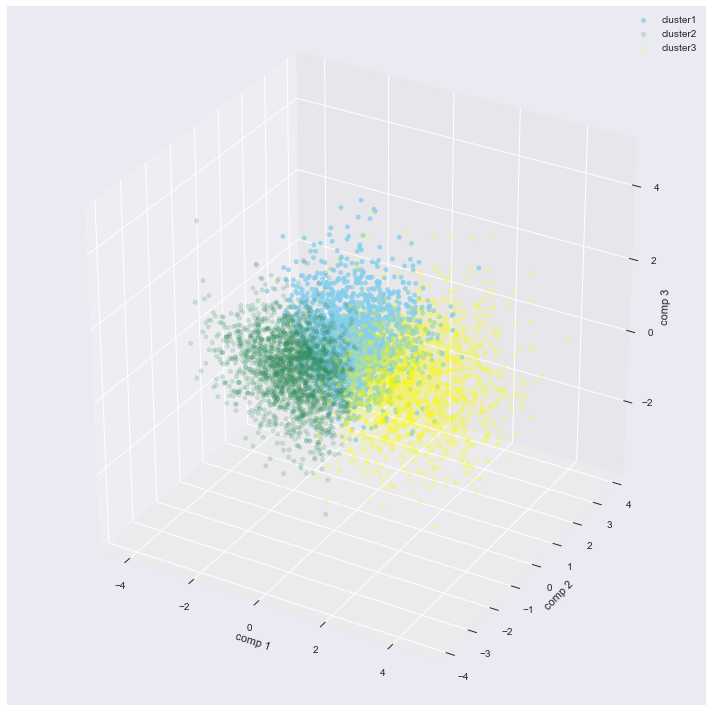

In [33]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig3d = plt.figure(figsize=(10, 10))
ax = fig3d.add_subplot(111, projection='3d')

p = ax.scatter(c1['pca1'], c1['pca2'], c1['pca3'], color='skyblue', alpha=0.8, label='cluster1')
p = ax.scatter(c2['pca1'], c2['pca2'], c2['pca3'], color='seagreen', alpha=0.2, label='cluster2')
p = ax.scatter(c3['pca1'], c3['pca2'], c3['pca3'], color='yellow', alpha=0.2, label='cluster3')
ax.set_xlabel('comp 1')
ax.set_ylabel('comp 2')
ax.set_zlabel('comp 3')

ax.legend()
fig3d.tight_layout()
plt.savefig('../images/KMeans3D_PCA1_3_N6.png')


Plotting the same PCA components below colored by the tagged genre of the songs (pop vs country), we will notice the overlapping feature values between the two genres.

In [35]:
country = songsDF[songsDF.genre == 'country']
pop     = songsDF[songsDF.genre == 'pop']

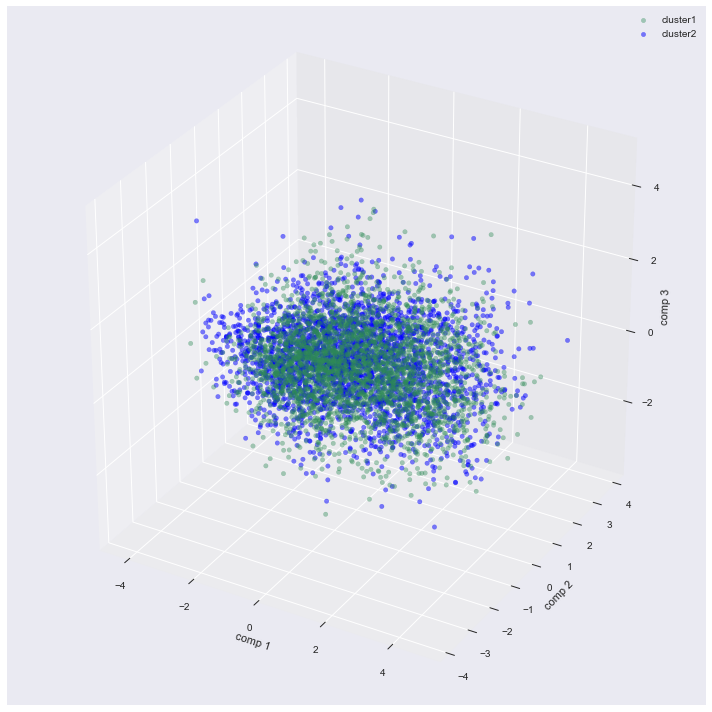

In [36]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig3d = plt.figure(figsize=(10, 10))
ax = fig3d.add_subplot(111, projection='3d')

p = ax.scatter(country['pca1'], country['pca2'], country['pca3'], color='seagreen', alpha=0.4, label='cluster1')
p = ax.scatter(pop['pca1'], pop['pca2'], pop['pca3'], color='blue', alpha=0.5, label='cluster2')
ax.set_xlabel('comp 1')
ax.set_ylabel('comp 2')
ax.set_zlabel('comp 3')

ax.legend()
fig3d.tight_layout()
plt.savefig('../images/KMeans3D_PCA1_3_CountryPop.png')


## Let us look deeper into the resulting cluster features, to see how our KMeans clustering broke down our clusters:

Scale the timbre_med column so that all features are in 0-1 range for the spider plot.

In [37]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
songsDF['timbre_med_scaled'] = scaler.fit_transform(songsDF[['timbre_med']])

In [38]:
def clustSummary(col, k):
    clust_summ = {'group':[], 'danceability':[], 'energy':[],
                  'acousticness': [], 'valence': [], 'pitch':[], 'timbre':[]}

    for num in range(k):
        clust_summ['group'].append('Cluster{}'.format(num))
        clust_summ['danceability'].append(songsDF[songsDF[col] == num]['danceability'].median())
        clust_summ['energy'].append(songsDF[songsDF[col] == num]['energy'].median())
        clust_summ['acousticness'].append(songsDF[songsDF[col] == num]['acousticness'].median())
        clust_summ['valence'].append(songsDF[songsDF[col] == num]['valence'].median())
        clust_summ['pitch'].append(songsDF[songsDF[col] == num]['pitch_med'].median())
        clust_summ['timbre'].append(songsDF[songsDF[col] == num]['timbre_med_scaled'].median())
        
    return clust_summ;

In [39]:
KM3_clust_df = pd.DataFrame(clustSummary('K_cluster_n3',3))[['group','danceability','energy','acousticness','valence','pitch','timbre']]
KM3_clust_df

,group,danceability,energy,acousticness,valence,pitch,timbre
0,Cluster0,0.448,0.786,0.0198,0.398,0.2310,0.420202
1,Cluster1,0.642,0.732,0.1080,0.726,0.2365,0.467765
2,Cluster2,0.517,0.350,0.6730,0.263,0.1315,0.349806


Create Spider plot to visualize the three clusters identified by K-Means

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

In [41]:
def getClusterSummResults(clustLabel, k=3):
    ''' returns a dataframe with summarized results for the clustering method'''
    
    clust_summ = {'cluster':[],'mSong_tag':[],'count':[], 'Pct Overall Genre': []}
    
    total_msong_pop = songsDF[(songsDF.genre == 'pop')].song_id.count()
    total_msong_country = songsDF[(songsDF.genre == 'country')].song_id.count()
    
    for num in range(k):
        clust_count_cntry = songsDF[(songsDF[clustLabel] == num) & (songsDF.genre == 'country')].song_id.count()
        clust_count_pop   = songsDF[(songsDF[clustLabel] == num) & (songsDF.genre == 'pop')].song_id.count()
    
    
        clust_summ['cluster'].append(num)
        clust_summ['mSong_tag'].append('country')
        clust_summ['count'].append(clust_count_cntry)
        clust_summ['Pct Overall Genre'].append(clust_count_cntry/total_msong_country*100)
    
        clust_summ['cluster'].append(num)
        clust_summ['mSong_tag'].append('pop')
        clust_summ['count'].append(clust_count_pop)
        clust_summ['Pct Overall Genre'].append(clust_count_pop/total_msong_pop*100)

    
    summDF = pd.DataFrame(clust_summ)
    summDF = summDF[['cluster','mSong_tag','count','Pct Overall Genre']].copy()
    return summDF

In [42]:
def plotClusterSpider(KM_clust_df):
    my_palette = plt.cm.get_cmap("Set2", len(KM_clust_df.index))

    plt.figure(figsize=(20,8))

    for row in range(0, len(KM_clust_df.index)):
    
        categories=list(KM_clust_df)[1:]
        N = len(categories)
        title='group '+KM_clust_df['group'][row]
        color=my_palette(row)
 
        # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
        angles = [n / float(N) * 2 * pi for n in range(N)]
        angles += angles[:1]
    

    
        # Initialise the spider plot
        ax = plt.subplot(1,3,row+1, polar=True, )
        #ax = plt.subplot(110+(row+1), polar=True, )
 
        # If you want the first axis to be on top:
        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)
 
        # Draw one axe per variable + add labels labels yet
        plt.xticks(angles[:-1], categories, color='grey', size=12)
 
        # Draw ylabels
        ax.set_rlabel_position(0)
        plt.yticks(np.linspace(0,1.0,5), [str(x) for x in np.linspace(0,1.0,5)], color="grey", size=10)
        plt.ylim(0,1)
 
        # Ind1
        values=KM_clust_df.loc[row].drop('group').values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
        ax.fill(angles, values, color=color, alpha=0.4)
 
        # Add a title
        plt.title(title, size=11, color=color, y=1.1, fontsize=20)

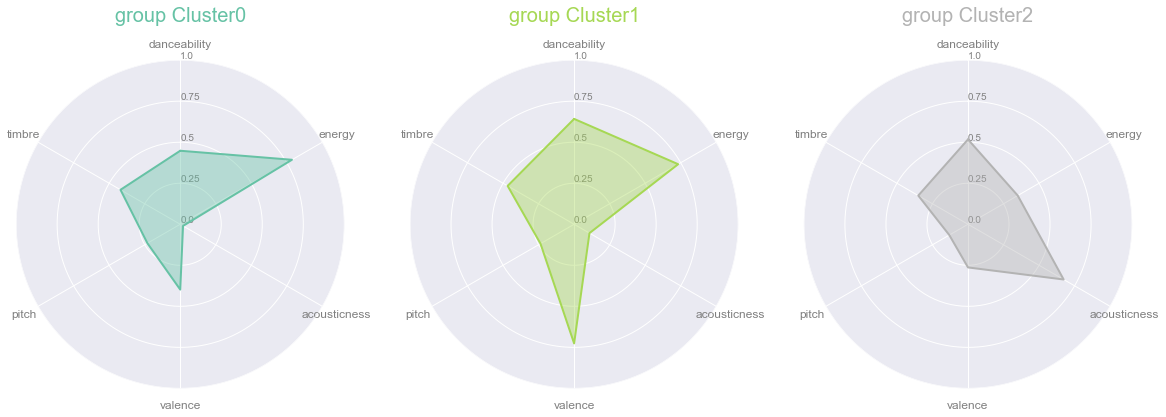

In [43]:
plotClusterSpider(KM3_clust_df)

### Cluster Summary - KMeans (k=3)

#### The three song clusters are broken down into the following features:
<br> __Cluster 0__ - high energy, low valence, high pitch, low acoustic
<br> __Cluster 1__ - High energy, high danceability, high valence, high timbre
<br> __Cluster 2__ - lower energy, high acoustic, lowest valence, low timbre, low pitch

The main distinguishing features appear to be __Energy__, __Acousticness__, and __valence__.

We can see from how our songs were broken down to these three clusters that there are almost same percentages of country songs and pop songs.  There are a little more pop songs in Clusters 0 and 1 (high energy, low acoustic clusters), and a little more country in cluster 2 (high acoustic cluster).  

In [276]:
KMeansDF3 = getClusterSummResults('K_cluster_n3')
KMeansDF3

,cluster,mSong_tag,count,Pct Overall Genre
0,0,country,915,29.678884
1,0,pop,894,31.951394
2,1,country,1035,33.571197
3,1,pop,959,34.274482
4,2,country,1133,36.749919
5,2,pop,945,33.774124


### Below are some sample songs which were classified into each of the three clusters.
Artists' songs do not belong to just one classification of song, such as for Beyonce and Keith Urban below. Where we will find their songs classified in all of the three clusters.

###  Cluster 0
<br>[Beyonce Irreplaceable 2006](https://www.youtube.com/watch?v=2EwViQxSJJQ)
<br>[Keith Urban Raining on Sunday 2002 ](https://www.youtube.com/watch?v=DgV7RG9Qgvk)
<br>[Martina McBride So Magical - 2003](https://www.youtube.com/watch?v=sgBqG3bRH7I)

<br>[Celine Dion    Can't Fight the Feeling-2007](https://www.youtube.com/watch?v=88SXDM68fl4)      
<br>[Britney Spears Touch of My Hand 2003](https://www.youtube.com/watch?v=-SnQcYcG41U)
[Billy Currington That's Just Me     2003](https://www.youtube.com/watch?v=SqkmGGii6ZI)
<br>[One Republic   Apologize 2007](https://www.youtube.com/watch?v=ZSM3w1v-A_Y)
[Keith Urban   Raining on Sunday  2002](https://www.youtube.com/watch?v=DgV7RG9Qgvk)


### Cluster 1
<br>[Beyonce Crazy In Love 2003](https://www.youtube.com/watch?v=ViwtNLUqkMY)
<br>[Keith Urban - Somebody Like You 2002](https://www.youtube.com/watch?v=eiBinM-f-Pk)
[Christina Aguilera Ain't No Other Man 2006](https://www.youtube.com/watch?v=8x7Ta89QLo4)
<br>[Whitney Houston I'm Every Woman 1992]
<br>[Justin Bieber Runaway Love 2010] 

[Billy Currington  Ain't What it Used to Be 2003](https://www.youtube.com/watch?v=AgUGUrD5zc4)
<br> [Rascal Flatts     Fast Cars and Freedom  2004](https://www.youtube.com/watch?v=ZsilfOVRX3U)
<br>[Martina McBride   You Ain't Woman Enough 2005](https://www.youtube.com/watch?v=KLoCza6GfXs)


### Cluster 2

<br>[Beyonce Dangerously in Love 2003](https://www.youtube.com/watch?v=wNCQUauSvkg)
<br>[Keith Urban You are Not Alone Tonight 2002](https://www.youtube.com/watch?v=-KkrfwcwPL0)

<br>Christina Aguilera  Walk Away 2002
<br>Beyonce Dangerously in Love  2003
<br>Leona Lewis My Hands 2009

<br>Rascal Flats  Bless the Broken Road 2004

<br>Lady Antebellum  American Honey 2009



In [85]:
#songsDF[(songsDF.genre == 'pop')].groupby(['artist_name','K_cluster_n3'])['year'].value_counts()

In [73]:
#songsDF[(songsDF.artist_id == 'AR95IYB1187FB3FE0B') & (songsDF.K_cluster_n3 == 2)][['title','year']]

### Cluster 0 - high energy, low valence, high pitch, low acoustic

In [31]:
songsDF[songsDF.K_cluster_n3 == 0][features ].describe()  

,danceability,energy,acousticness,valence,pitch_med,timbre_med
count,1809.000000,1809.000000,1809.000000,1809.000000,1809.000000,1809.000000
mean,0.437602,0.771189,0.080596,0.403753,0.246945,0.293282
std,0.112212,0.144555,0.129136,0.164705,0.074600,2.578910
min,0.000000,0.000063,0.000002,0.000000,0.095250,-8.877000
25%,0.366000,0.663000,0.001190,0.280000,0.189250,-1.359750
50%,0.448000,0.786000,0.019800,0.398000,0.231000,0.250000
75%,0.519000,0.894000,0.110000,0.519000,0.298500,1.920500
max,0.733000,0.999000,0.989000,0.965000,0.547000,9.700500


### Cluster 1 - High energy, high danceability, high valence, high timbre

In [37]:
songsDF[songsDF.K_cluster_n3 == 1][features ].describe() 

,danceability,energy,acousticness,valence,pitch_med,timbre_med
count,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000
mean,0.649138,0.716218,0.185554,0.715954,0.240980,1.829209
std,0.094640,0.159070,0.205722,0.152384,0.060456,2.906276
min,0.321000,0.071100,0.000009,0.178000,0.076500,-9.486500
25%,0.584250,0.602000,0.025725,0.608000,0.197000,-0.109438
50%,0.642000,0.732000,0.108000,0.726000,0.236500,1.781000
75%,0.708000,0.845000,0.280000,0.838000,0.278875,3.744500
max,0.938000,0.999000,0.992000,0.982000,0.477250,18.913250


### Cluster 2 - lower energy, high acoustic, lowest valence, low timbre, low pitch

In [38]:
songsDF[songsDF.K_cluster_n3 == 2][features ].describe()  

,danceability,energy,acousticness,valence,pitch_med,timbre_med
count,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000
mean,0.499639,0.343905,0.617959,0.292769,0.134932,-2.007828
std,0.137865,0.139952,0.269359,0.164111,0.040041,3.296216
min,0.000000,0.000020,0.000002,0.000000,0.036250,-13.276000
25%,0.409000,0.244000,0.430250,0.169250,0.106813,-4.156937
50%,0.517000,0.350000,0.673000,0.263000,0.131500,-2.016000
75%,0.598000,0.446000,0.844000,0.390750,0.159500,0.066625
max,0.883000,0.789000,0.996000,0.966000,0.311750,13.745000


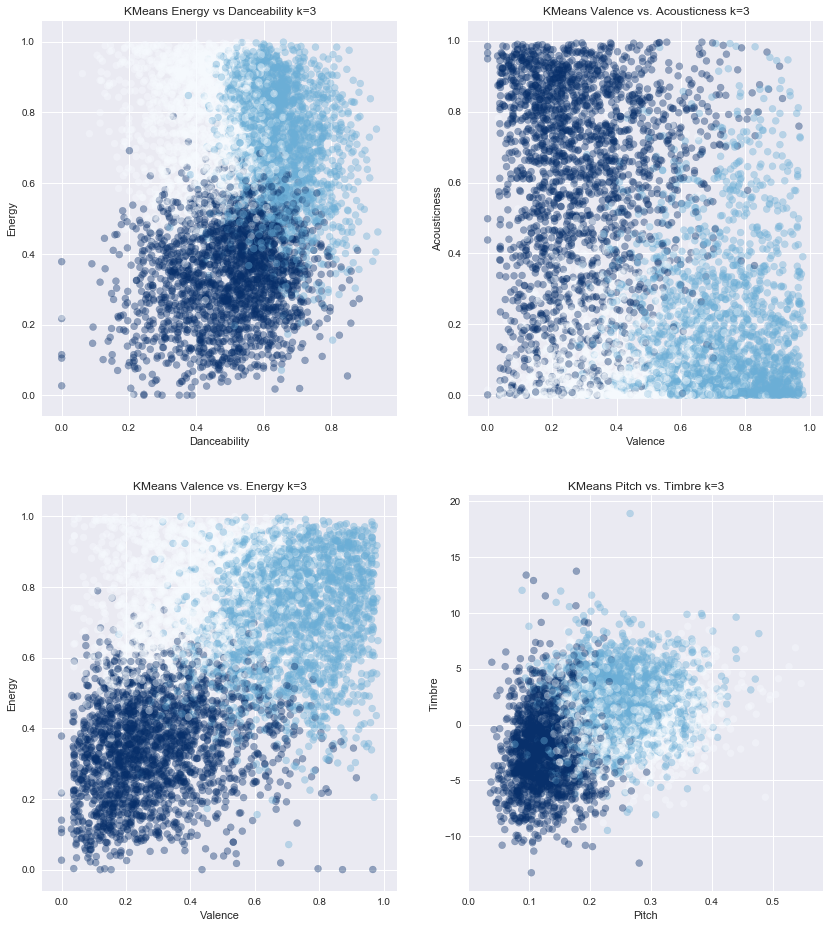

In [127]:
fig = plt.figure(figsize=(14,16))


ax1=plt.subplot(2, 2, 1)
ax1.scatter(songsDF['danceability'],songsDF['energy'],marker='o',c=songsDF['K_cluster_n3'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Danceability')
plt.ylabel('Energy')
ax1.set_title('KMeans Energy vs Danceability k=3')


ax2=plt.subplot(2, 2, 2)
ax2.scatter(songsDF['valence'],songsDF['acousticness'],marker='o',c=songsDF['K_cluster_n3'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Valence')
plt.ylabel('Acousticness')
ax2.set_title('KMeans Valence vs. Acousticness k=3')


ax3=plt.subplot(2, 2, 3)
ax3.scatter(songsDF['valence'],songsDF['energy'],marker='o',c=songsDF['K_cluster_n3'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Valence')
plt.ylabel('Energy')
ax3.set_title('KMeans Valence vs. Energy k=3')

ax4=plt.subplot(2, 2, 4)
ax4.scatter(songsDF['pitch_med'],songsDF['timbre_med'],marker='o',c=songsDF['K_cluster_n3'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3) )
plt.xlabel('Pitch')
plt.ylabel('Timbre')
ax4.set_title('KMeans Pitch vs. Timbre k=3')

plt.savefig('../images/KMeans_FeaturesClusters_K3.png')

## Let us explore how the clusters will be divided if we just create two clusters (k=2)

In [44]:
km = KMeans(n_clusters=2, random_state=0)
km.fit_transform(Xtr)
cluster_labels = km.labels_
songsDF['K_cluster_n2'] = cluster_labels

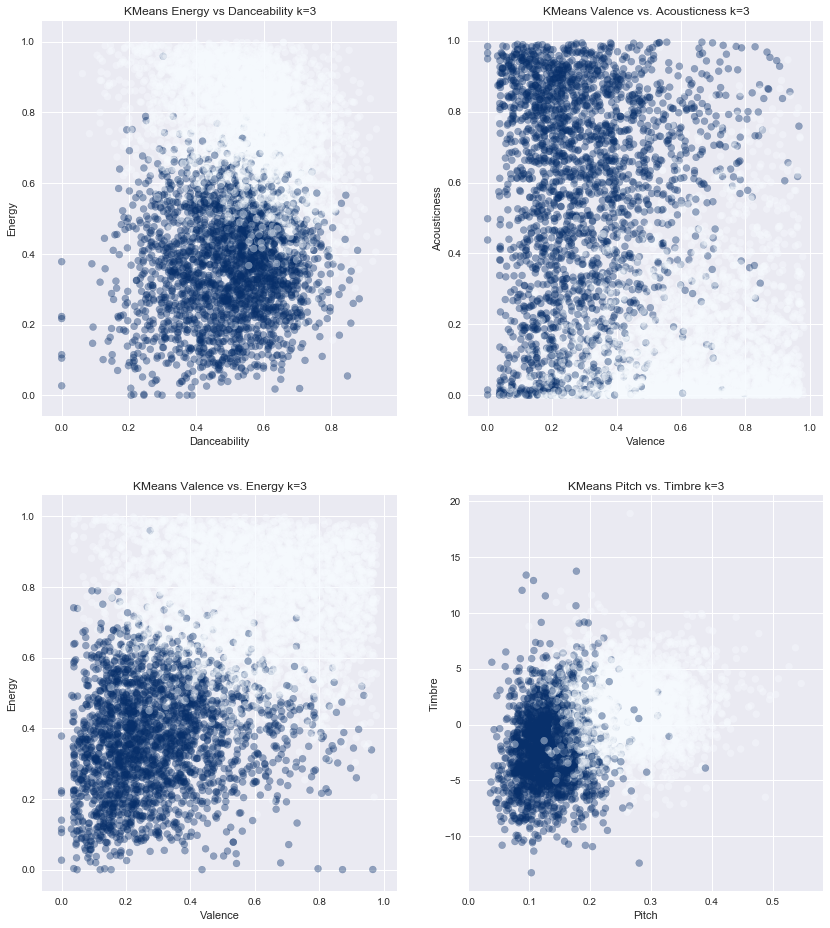

In [45]:
fig = plt.figure(figsize=(14,16))


ax1=plt.subplot(2, 2, 1)
ax1.scatter(songsDF['danceability'],songsDF['energy'],marker='o',c=songsDF['K_cluster_n2'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Danceability')
plt.ylabel('Energy')
ax1.set_title('KMeans Energy vs Danceability k=3')


ax2=plt.subplot(2, 2, 2)
ax2.scatter(songsDF['valence'],songsDF['acousticness'],marker='o',c=songsDF['K_cluster_n2'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Valence')
plt.ylabel('Acousticness')
ax2.set_title('KMeans Valence vs. Acousticness k=3')


ax3=plt.subplot(2, 2, 3)
ax3.scatter(songsDF['valence'],songsDF['energy'],marker='o',c=songsDF['K_cluster_n2'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Valence')
plt.ylabel('Energy')
ax3.set_title('KMeans Valence vs. Energy k=3')

ax4=plt.subplot(2, 2, 4)
ax4.scatter(songsDF['pitch_med'],songsDF['timbre_med'],marker='o',c=songsDF['K_cluster_n2'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3) )
plt.xlabel('Pitch')
plt.ylabel('Timbre')
ax4.set_title('KMeans Pitch vs. Timbre k=3')

plt.savefig('../images/KMeans_FeaturesClusters_K2.png')

In [46]:
KM2_clust_df = pd.DataFrame(clustSummary('K_cluster_n2',2))[['group','danceability','energy','acousticness','valence','pitch','timbre']]
KM2_clust_df

,group,danceability,energy,acousticness,valence,pitch,timbre
0,Cluster0,0.566,0.775,0.0516,0.590,0.2405,0.446298
1,Cluster1,0.508,0.371,0.6310,0.266,0.1370,0.356792


Similar to the 3-cluster output, the main distinguishing features appear to be __Energy__, __Acousticness__, and __valence__.

Cluster 0 - has high energy, high valence, and low acousticness,
whereas
<br>Cluster 1 - has high acousticness, low energy, and low valence.

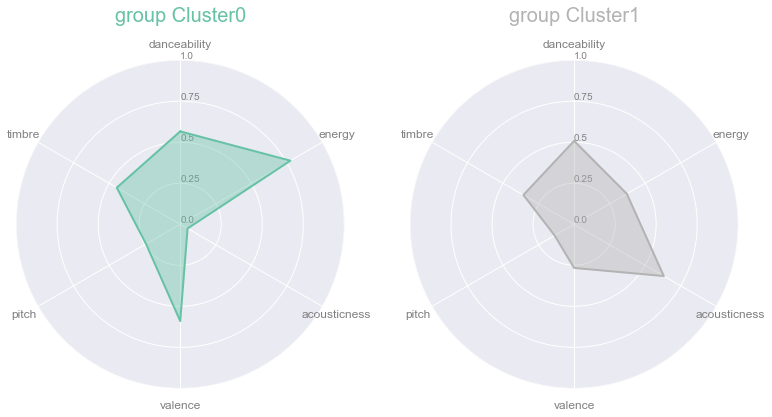

In [47]:
plotClusterSpider(KM2_clust_df)

And checking again how the different (country and pop songs) genres were split into these two clusters, we will still see a huge overlap between the two genres, and that more pop songs are classified as cluster 0 (high energy, low acoustic), and more country songs are classified as Cluster 1 (high acoustic, low energy).

In [50]:
KMeansDF2 = getClusterSummResults('K_cluster_n2',2)
KMeansDF2

,cluster,mSong_tag,count,Pct Overall Genre
0,0,country,1793,58.157639
1,0,pop,1724,61.615440
2,1,country,1290,41.842361
3,1,pop,1074,38.384560


In [46]:
num_songs = 300

In [47]:
country = songsDF[songsDF.genre == 'country']
pop = songsDF[songsDF.genre == 'pop']

In [48]:
Top_songs = songsDF[songsDF.artist_hotttnesss > 0.5].sort_values('song_id', ascending=False).head(num_songs)

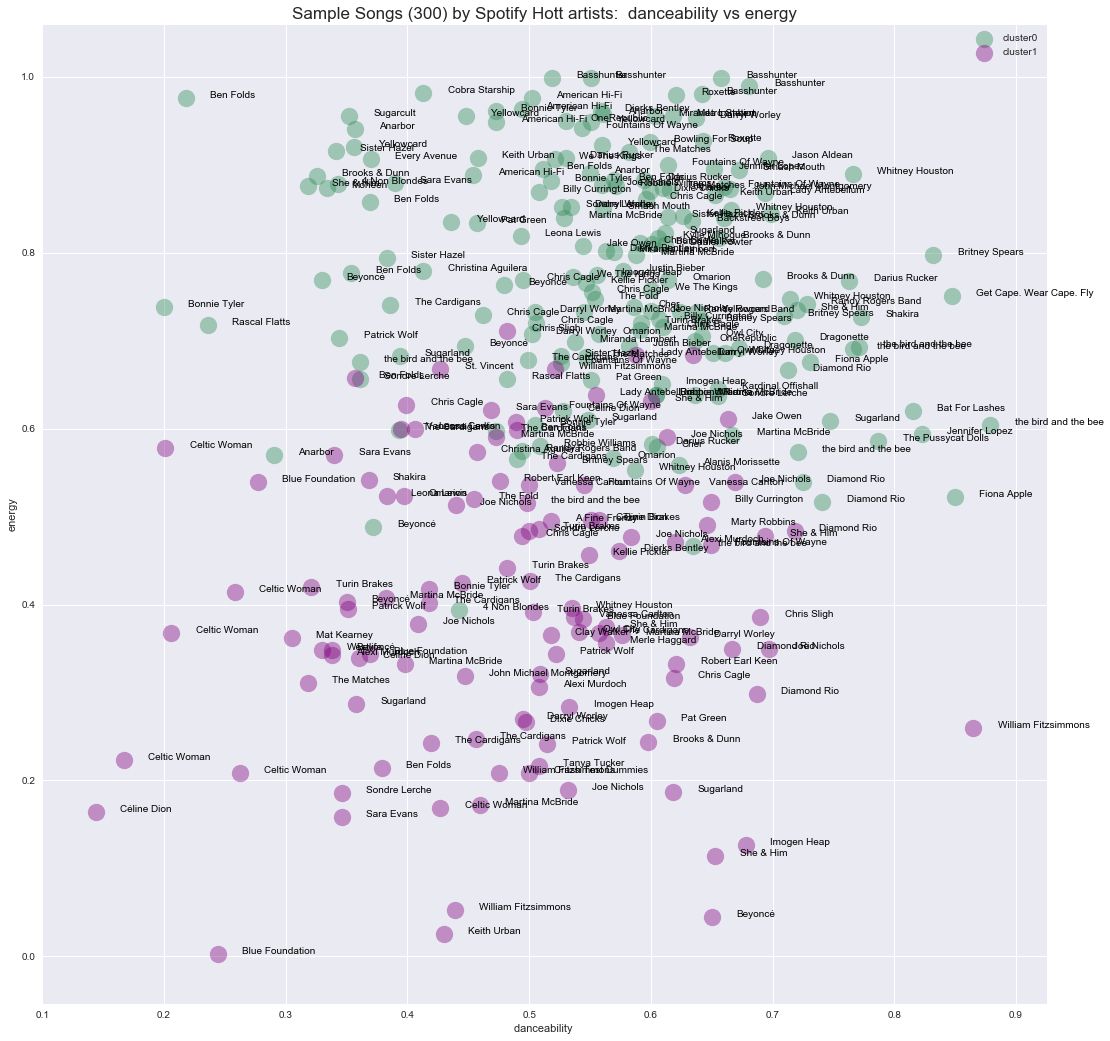

In [49]:
fig = plt.figure(figsize=(18,18))
p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n2 == 0] ,x='danceability', y='energy', fit_reg=False, marker="o", color='seagreen',
                           scatter_kws={'s':300, 'alpha':0.4},label='cluster0')
p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n2 == 1] ,x='danceability', y='energy', fit_reg=False, marker="o", color='purple',
                           scatter_kws={'s':300, 'alpha':0.4},label='cluster1')
#p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n3 == 2] ,x='danceability', y='energy', fit_reg=False, marker="o", color='red',
#                           scatter_kws={'s':300, 'alpha':0.4},label='cluster2')
for line in range(0,Top_songs.shape[0]):
    p1.text(Top_songs.danceability.iloc[line] + 0.02, Top_songs.energy.iloc[line], Top_songs.artist_name.iloc[line],
            horizontalalignment='left', size='medium',color='black')
p1.set_xlabel('danceability ')
p1.set_ylabel('energy')
plt.legend()
p1.set_title('Sample Songs ({}) by Spotify Hott artists:  danceability vs energy'.format(num_songs), fontsize=17)
plt.savefig('../images/Songs_dance_energy_Kmeans.png')

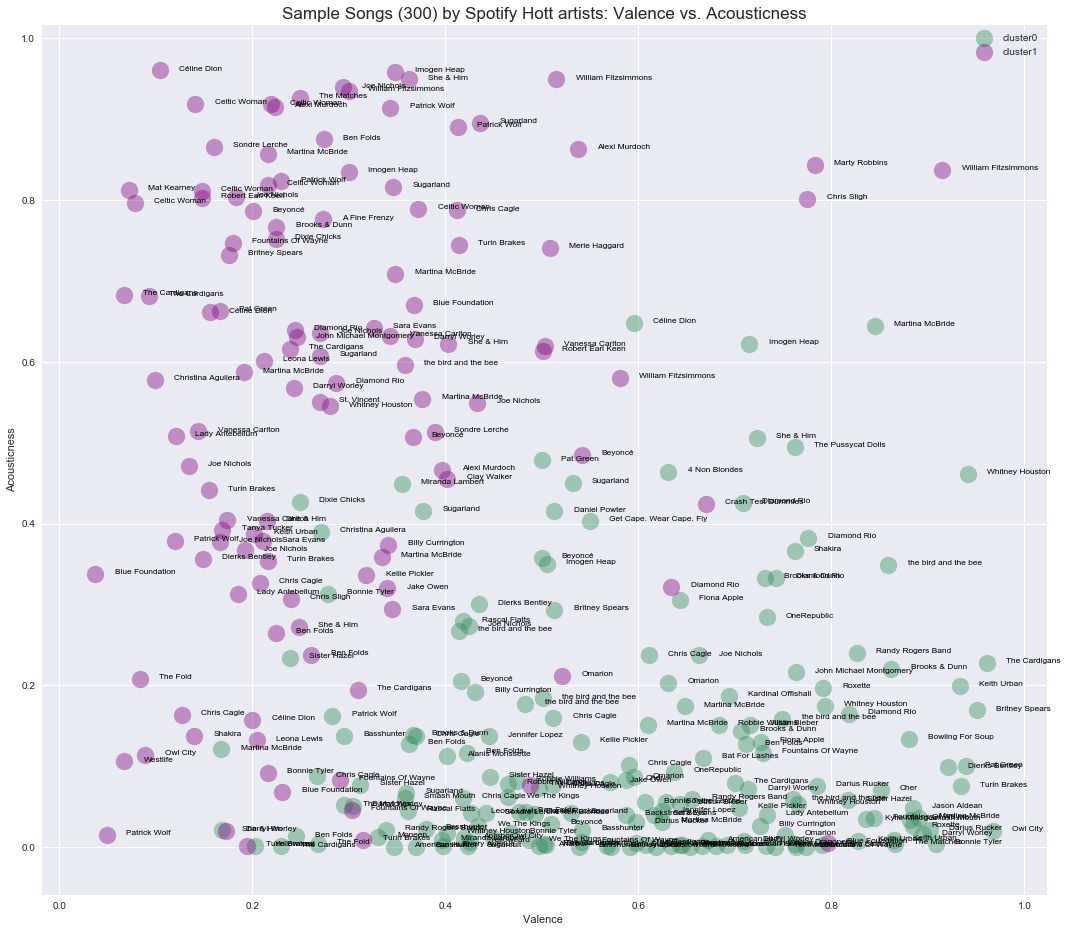

In [50]:
fig = plt.figure(figsize=(18,16))
p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n2 == 0] ,x='valence', y='acousticness', fit_reg=False, marker="o", color='seagreen',
                           scatter_kws={'s':300, 'alpha':0.4},label='cluster0')
p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n2 == 1] ,x='valence', y='acousticness', fit_reg=False, marker="o", color='purple',
                           scatter_kws={'s':300, 'alpha':0.4},label='cluster1')

for line in range(0,Top_songs.shape[0]):
    p1.text(Top_songs.valence.iloc[line] + 0.02, Top_songs.acousticness.iloc[line], Top_songs.artist_name.iloc[line],
            horizontalalignment='left', size='small',color='black')
p1.set_xlabel('Valence ')
p1.set_ylabel('Acousticness')
plt.legend()
p1.set_title('Sample Songs ({}) by Spotify Hott artists: Valence vs. Acousticness'.format(num_songs), fontsize=17)
plt.savefig('../images/Songs_Valence_Acousticness_Kmeans.png')

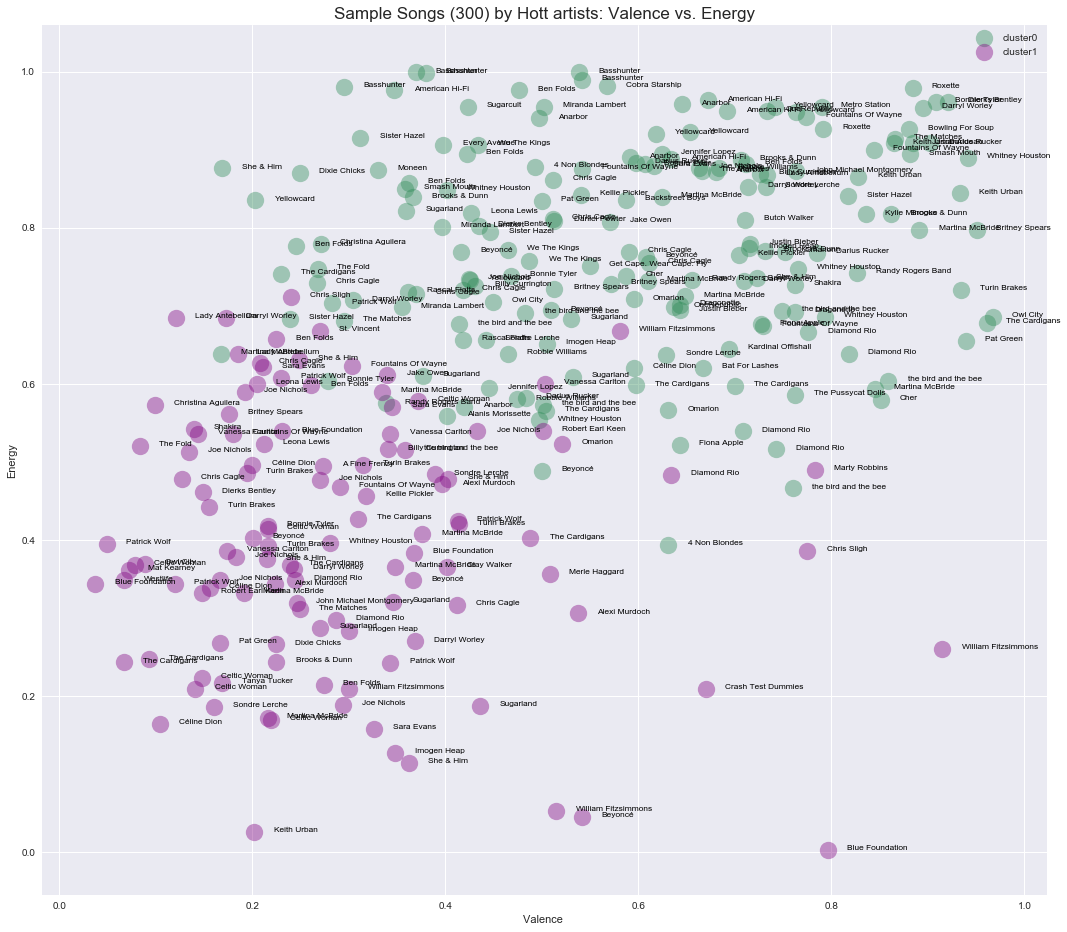

In [51]:
fig = plt.figure(figsize=(18,16))
p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n2 == 0] ,x='valence', y='energy', fit_reg=False, marker="o", color='seagreen',
                           scatter_kws={'s':300, 'alpha':0.4},label='cluster0')
p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n2 == 1] ,x='valence', y='energy', fit_reg=False, marker="o", color='purple',
                           scatter_kws={'s':300, 'alpha':0.4},label='cluster1')
#p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n3_9 == 2] ,x='valence', y='energy', fit_reg=False, marker="o", color='red',
#                           scatter_kws={'s':300, 'alpha':0.4},label='cluster2')
for line in range(0,Top_songs.shape[0]):
    p1.text(Top_songs.valence.iloc[line] + 0.02, Top_songs.energy.iloc[line], Top_songs.artist_name.iloc[line],
            horizontalalignment='left', size='small',color='black')
p1.set_xlabel('Valence ')
p1.set_ylabel('Energy')
p1.set_title('Sample Songs ({}) by Hott artists: Valence vs. Energy'.format(num_songs), fontsize=17)
plt.legend()
plt.savefig('../images/Songs_Valence_Energy_Kmeans.png')

### What we have found so far is that we cannot distinguish a country song vs a pop songs from the Audio Features:  Acousticness, Danceability, Valence, Energy, Pitch and Timbre.  High Acousticness may just be a more common feature of country song, and High Energy and High Valence for pop songs, but they are not a unique feature for those genres, as we have seen in the large overlap between these two genres in our clusters.

update here: https://www.allmusic.com/style/country-pop-ma0000004416


### Let us see if we can get some insights/patterns from the Lyrics of our songs.

## Text Analysis

### Tokenization and Building Vocabulary

In [86]:
import nltk
import string
from nltk.corpus import stopwords as sw
from nltk.stem.porter import PorterStemmer
from numba import jit
from nltk.tokenize import TreebankWordTokenizer, WordPunctTokenizer, WhitespaceTokenizer

In [87]:
porterStemmer = PorterStemmer()
translator = str.maketrans(string.punctuation, ' '*32)
stopwords_dict = set(sw.words('english'))



def stemTokenList(tokens,stemmer):
    return [stemmer.stem(token) for token in tokens]

#get stemmed tokens from text
def noPunctWordTokenizerStemmer(text, stemmer=porterStemmer):
    #basic tokens to feed to our stem tokenizer
    tokens = nltk.word_tokenize(text.translate(translator))
    #stem
    stemmed_tokens = stemTokenList(tokens, stemmer)
    return stemmed_tokens

In [88]:
from gensim.corpora.dictionary import Dictionary
lyrics = list(songsDF.lyrics_clean.values)
tokenized_docs = [noPunctWordTokenizerStemmer(lyr) for lyr in lyrics]
dictionary = Dictionary(tokenized_docs)

In [ ]:
dictionary.token2id

#### Get Overall Term Frequency

Using TF-IdF

In [90]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

counter = CountVectorizer(stop_words='english', tokenizer=noPunctWordTokenizerStemmer)
feature_counts = counter.fit_transform(songsDF['lyrics_clean'].values)
feature_names = counter.get_feature_names()

In [48]:
#transform sparse count matrix to normalized tf-idf representation using TfidfTransformer
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(use_idf=True, smooth_idf=True, sublinear_tf=True)
features_tfidf = tfidf.fit_transform(feature_counts)

print('tfidf matrix of {} songs with {} tokens'.format(features_tfidf.shape[0],features_tfidf.shape[1]))

tfidf matrix of 5881 songs with 15705 tokens


/Users/ayeshamendoza/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [49]:
counter.get_feature_names()[:10]

['0', '00', '000', '010110', '06', '09', '0ut', '1', '10', '100']

In [50]:
tv = TfidfVectorizer(stop_words='english', tokenizer=noPunctWordTokenizerStemmer)
tv_mat = tv.fit_transform(songsDF['lyrics_clean'].values)

/Users/ayeshamendoza/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [52]:
tv_mat = tv_mat.toarray()
vocab = tv.get_feature_names()
tvDF = pd.DataFrame(tv_mat, columns=vocab)


### LDA

In [53]:
import numpy as np

In [87]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_topics=4, learning_method='batch')
#lda.fit(feature_counts)
lda.fit(tv_mat) #using tfidfVectorizer

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_jobs=1, n_topics=4, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [88]:
lda.components_.shape

(4, 15705)

In [89]:
#Visualize the LDA term-by-topics matrix
print(lda.components_[0].argsort()[:-10-1:-1])
print(sorted(lda.components_[0], key = lambda x: -x)[0:10])

print(np.sum(lda.components_[0]))
print(np.sum(sorted(lda.components_[0], key=lambda x: -x)[0:500]))
      

[ 3373  4235  8365  2436 14237 15368  4040  8635 14126 14252]
[11.349035105952451, 6.442060000762079, 3.481141686272862, 2.3746304594346435, 2.33508327233124, 1.8441881140935532, 1.714935584077669, 1.6145144226601773, 1.601303454894631, 1.4216104750505552]
4191.6947673104405
313.1526790990023


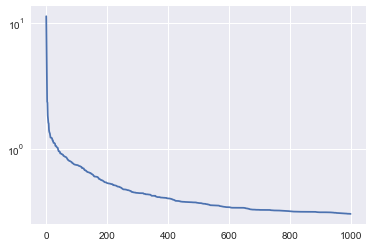

In [90]:
%matplotlib inline
plt.plot(sorted(lda.components_[0], key= lambda x: -x)[0:1000])
plt.yscale('log')



### Transform Data to Topics

In [91]:
#Topics by Document Matrix
docTopics = lda.transform(tv_mat)
print(docTopics.shape)

(5881, 4)


In [92]:
def topicsToDict(components, names, n_tokens=20):
    topicsDict = {}
    for topic_id, topic in enumerate(components):
        topicsDict[str(topic_id)] = [names[i] for i in topic.argsort()[:-n_tokens-1:-1]]
    return topicsDict

In [94]:
#Print resulting topics top words
topicDict = topicsToDict(lda.components_, feature_names)
for topic in topicDict:
    print()
    print(topic, ':', topicDict[topic])


0 : ['da', 'dum', 'maria', 'cheeki', 'tu', 'wonderland', 'donna', 'mi', 'travi', 'tulsa', 'record', 'sleigh', 'mindset', 'doobi', 'partial', 'idiot', 'treacheri', 'soley', 'bla', 'didio']

1 : ['s', 't', 'm', 'love', 'don', 'know', 'll', 'just', 'thi', 'like', 'time', 've', 'oh', 'wa', 'come', 'got', 'let', 'want', 'na', 'feel']

2 : ['jane', 'ding', 'dong', 'unlov', 'ella', 'gloria', 'boomerang', 'bodyguard', 'itali', 'darlen', 'candylion', 'won\x92t', 'cholera', 'julia', 'amplifi', 'staci', 'freakshow', 'olden', 'nightlif', 'graceland']

3 : ['carolin', 'happier', 'nigga', 'whatcha', 'clone', 'georgia', 'chelsea', 'caledonia', 'ghetto', 'la', 'di', 'volcano', 'carousel', 'masquerad', 'e', 'solitair', 'hawaii', 'chevrolet', 'danni', 'che']


In [95]:
top_col = ['T'+ str(x) for x in range(1,5)]

Tfeatures = pd.DataFrame(docTopics, columns=top_col)

In [96]:
Tfeatures.shape

(5881, 4)

Let us see if the topics/words will have more meaning if we do not stem the words

In [93]:
tv = TfidfVectorizer(stop_words=set(sw.words('english')),
                                   smooth_idf=False)

tfidf2 = tv.fit_transform(songsDF['lyrics_clean'].values)

/Users/ayeshamendoza/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [94]:
tfidf2 = tfidf2.toarray()
vocab = tv.get_feature_names()
tvDF = pd.DataFrame(tfidf2, columns=vocab)



In [96]:
tvDF.head()

,00,000,010110,06,09,0ut,10,100,100110,100th,101,1040,105,11,110,1100,118,12,123,1234567,129,13,14,14th,15,16,160,16th,17,18,180,1836,19,1912,1925,1936,1950,1950s,1960,1967,1969,1970,1971,1972,1973,1979,1983,1985,1986,1987,1988,1989,1993,1994,1997,1999,1e7,1ph,1st,1stalagmites,1t,20,200,2000,200037,2001,2002,2003,2005,2006,2044,20p,21,21st,22,22nd,23,232,24,240,25,256,26,27,27th,291,297,2am,2gether,2nd,2pac,2way,2x,30,3000,3015,305,30mls,31,312,313,32,33,34,35,360,364,369,37,3a,3am,3p,3x,40,400,405,409,40s,41,411,416,42,423,43,44,45,47,48,480ut,49,4913,4h,4sho,4th,4x,50,500,52,54,55,57,5am,5ft,5th,5ure,60,600,61,61st,62,63,65,66,68,69,6g,6th,70,700,709,71,736,745,747,75,7657,7784,78,7am,7th,80,800,81,83,84,840,85,87,8th,90,911,92,93,94,95,99,9am,9th,___________that,a13,aa,aaaaaaaah,aaaaaaaahhhhhhhhh,aaaaarrrggghhh,aaaah,aaaarrrggghhhh,aaah,aaai,aah,aahaaa,aahhhh,aaiming,aaron,aback,abacus,abandon,abandoned,abandoning,abandons,abash,abate,abba,abbey,abbots,abbreviate,abbreviation,abbreviations,abc,abcdefghi,abdicate,abdication,abeam,abel,aberdeen,abhor,abide,abilene,ability,abitch,abject,ablaze,able,ables,ablove,aboard,abode,aboil,abomination,abominations,aboud,abound,abounds,abracadabra,abraham,abrasive,abroad,abseil,absence,absent,absentees,absolute,absolutely,absolution,absorb,absorbed,absorbing,absorption,abstinence,abstract,absurd,abuse,abused,abuseful,abusin,abyss,ac,acabando,academy,accelerate,accelerating,accent,accept,acceptance,accepted,accepting,accepts,access,accessory,accident,accidental,accidentally,accidents,acclaim,acclaimed,acclimatize,accomplish,accomplished,accomplishment,accord,according,accordingly,account,accounted,accounts,accpet,accrue,accusations,accuse,accused,accustomed,ace,aces,acetylene,ache,acheived,aches,achieve,achieved,achievers,achieving,achilles,achin,aching,achings,achtung,achy,acid,ack,ackee,acknowledge,acolytes,acordian,acorn,acquaintance,acquainted,acquired,acre,acres,acrobat,acrobatic,across,acrossed,act,acted,actin,acting,action,actions,activated,activates,active,actor,actors,actress,actresses,acts,actually,acute,ad,adam,adamant,adams,adapt,adaptation,add,added,adder,addict,addicted,addiction,addictions,addictive,adding,addition,additive,addled,addormenterã,address,addressed,addresses,adds,adelaide,adequate,adheres,adidas,adieu,adieux,adios,adjacently,adjust,adjusted,adjuster,admin,admiration,admire,admired,admiring,admission,admit,admits,admitt,admitted,admitting,adnim,adobe,adolescence,adolescent,adonis,adopting,adorable,adore,adored,adores,adoring,adorned,adrenaline,adrift,adulation,adult,adultery,adults,advance,advanced,advances,advantage,adventure,adventures,adventurous,adverse,advertise,advertised,advertisers,advertising,advice,advise,advised,advocate,aerial,aeroplan,aeroplane,aeroplanes,aesthetic,aesthetically,afar,affair,affairs,affect,affected,affection,affects,affend,affi,affirmative,affliction,afforadable,afford,affordability,affordable,afghanistan,afloat,afraid,africa,african,afro,aft,afta,afterall,afterglow,aftermath,afternoon,afternoons,afternoun,afterthought,afterthoughts,afterwards,ag,agaaaaaaaaaaaaaaain,agaaaain,agai,againthinkin,agave,age,aged,agenda,agent,ages,agga,aggi,aggravate,aggravation,aggression,aggressiveness,agile,agin,aging,agitation,aglow,agnes,ago,agony,agree,agreed,agreein,agreements,agrees,aground,agua,aguilera,agus,...,willing,willingly,willow,willows,willpower,wills,willy,wilson,wim,win,wince,winces,winchester,wind,windbags,windblown,winding,windmill,windmills,window,windowpane,windowpanes,windows,windowsill,windowsills,winds,windscreen,windshield,windswept,windy,wine,wined,wing,winged,winging,wings,wink,winked,winkin,winking,winkle,winkles,winks,winner,winners,winnin,winning,winnow,wino,wins,winslow,winsome,winston,winter,winterland,winters,wintertime,wio,wipe,wiped,wipers,wipes,wiping,wippoorwill,wir,wire,wired,wires,wiretap,wiring,wisconsin,wisdom,wise,wisely,wisemen,wiser,wish,wishbone,wished,wisher,wishes,wishful,wishin,wishing,wisper,wispher,wistf

In [102]:
from sklearn.decomposition import NMF
# fit NMF model
model = NMF(n_components=4, init='nndsvd', random_state=42)

W = model.fit_transform( tfidf2 )
H = model.components_

In [103]:
topic_names = tv.get_feature_names()
    
n_top_words = -1 * 20
num_topics = 4
word_dict = {};

for i in range(num_topics):
        
    #for each topic, obtain the largest values, and add the words they map to into the dictionary.
    words_ids = model.components_[i].argsort()[:n_top_words - 1:-1]
    words = [topic_names[key] for key in words_ids]
    word_dict['Song theme # ' + '{:02d}'.format(i+1)] = words;


In [104]:
topicDF = pd.DataFrame(word_dict)
topicDF

,Song theme # 01,Song theme # 02,Song theme # 03,Song theme # 04
0,know,love,baby,oh
1,time,heart,want,yeah
2,one,like,got,whoa
3,go,know,yeah,la
4,like,feel,girl,go
5,never,never,gonna,let
6,let,need,wanna,ooh
7,see,way,need,hey
8,get,true,let,uh
9,say,one,make,night


In [105]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_topics=4, learning_method='batch')
#lda.fit(feature_counts)
lda.fit(tfidf2) #using tfidfVectorizer

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_jobs=1, n_topics=4, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [106]:
#Visualize the LDA term-by-topics matrix
print(lda.components_[0].argsort()[:-10-1:-1])
print(sorted(lda.components_[0], key = lambda x: -x)[0:10])

print(np.sum(lda.components_[0]))
print(np.sum(sorted(lda.components_[0], key=lambda x: -x)[0:500]))
      

[20265 21982 16294  3975 21421  2999 15014 11757   749  1925]
[2.2119540377867697, 1.8444162274956732, 1.3793445915063771, 1.3668343095418398, 1.2804678966652865, 1.213479284891237, 1.1989433449969802, 1.1968417301977412, 1.1912276177133216, 1.1896596041734364]
5822.74513353018
297.31584683751873


In [107]:
#Topics by Document Matrix
docTopics = lda.transform(tfidf2)
print(docTopics.shape)

(5881, 4)


In [108]:
def topicsToDict(components, names, n_tokens=20):
    topicsDict = {}
    for topic_id, topic in enumerate(components):
        topicsDict[str(topic_id)] = [names[i] for i in topic.argsort()[:-n_tokens-1:-1]]
    return topicsDict

In [110]:
#Print resulting topics top words
topicDict = topicsToDict(lda.components_, vocab)
for topic in topicDict:
    print()
    print(topic, ':', topicDict[topic])


0 : ['tu', 'yay', 'rum', 'competition', 'weh', 'cariño', 'pum', 'marmalade', 'amplifier', 'bittersweetheart', 'darlene', 'maureen', 'iíve', 'sandokan', 'unlove', 'effington', '313', 'shule', 'stacy', 'oneplusone']

1 : ['dum', 'jane', 'mexican', 'harlan', 'donna', 'choo', 'cheeky', 'standard', 'complicator', 'peddlin', 'fol', 'beautyful', 'cholera', 'locomotion', 'teresa', 'judy', 'asylum', 'shanghai', 'medicines', 'lalalalalala']

2 : ['caroline', 'wonderland', 'est', 'mi', 'volcano', 'clone', 'organ', 'victorious', 'zaire', 'kokoro', 'treading', 'tidings', 'fidatevi', 'candylion', 'belfast', 'timor', 'elodie', 'merry', 'rachel', 'addictions']

3 : ['love', 'know', 'like', 'oh', 'one', 'time', 'go', 'never', 'let', 'see', 'get', 'got', 'baby', 'way', 'want', 'say', 'come', 'could', 'away', 'back']


### Model Train/Test

Perplexity - measure used for comparing how well probability based models make predictions.

In [100]:
from sklearn.model_selection import train_test_split
#import time

#train_features, test_features = train_test_split(feature_counts, test_size=0.3, random_state=1337 )
train_features, test_features = train_test_split(tv_mat, test_size=0.3, random_state=1337 )

In [101]:
#Create Dictionary to store results

ldaResults = {}
n_topics_list = [3,5,7,10,12,15,20,25]

for n_topics in n_topics_list:
    ldaResults[n_topics] = {}
    
#store the results for the model we already created (k=12)

#ldaResults[12]["perplexity"] = lda.perplexity(test_features)
#ldaResults[12]["topics"] = topicsToDict(lda.components_, feature_names)
ldaResults[10]["perplexity"] = lda.perplexity(test_features)
ldaResults[10]["topics"] = topicsToDict(lda.components_, vocab)

In [102]:
for n_topics in n_topics_list:
    print('Running LDA for n_topics = %d' % n_topics)
    if n_topics == 10:
        continue
    else:
        model = LatentDirichletAllocation(n_topics=n_topics, learning_method='batch' )
        model.fit(train_features)
        ldaResults[n_topics]["perplexity"] = model.perplexity(test_features)
        ldaResults[n_topics]["topics"] = topicsToDict(model.components_, vocab)

Running LDA for n_topics = 3
Running LDA for n_topics = 5
Running LDA for n_topics = 7
Running LDA for n_topics = 10
Running LDA for n_topics = 12
Running LDA for n_topics = 15
Running LDA for n_topics = 20
Running LDA for n_topics = 25


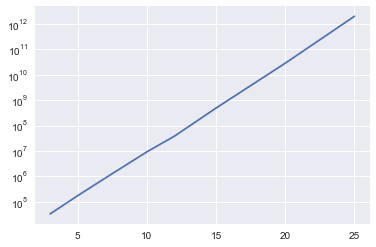

In [103]:
perplexity_arr = [ldaResults[topic]["perplexity"] for topic in n_topics_list]

plt.plot(n_topics_list, perplexity_arr);

plt.yscale('log')

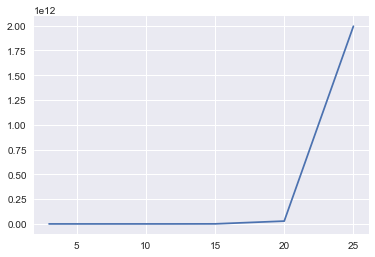

In [104]:
plt.plot(n_topics_list, perplexity_arr)

# Topic Modeling and K-Means clustering

In [102]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=4, random_state=0)
km.fit_transform(Tfeatures)
cluster_labels = km.labels_

In [97]:
def test(data, nClusterRange):
    inertias = np.zeros(len(nClusterRange))
    for i in range(len(nClusterRange)):
        model = KMeans(n_clusters=i+1, init='k-means++').fit(data)
        inertias[i] = model.inertia_
    return inertias

In [98]:
kRange = range(1,12)
KmeanTopics = test(Tfeatures, kRange)

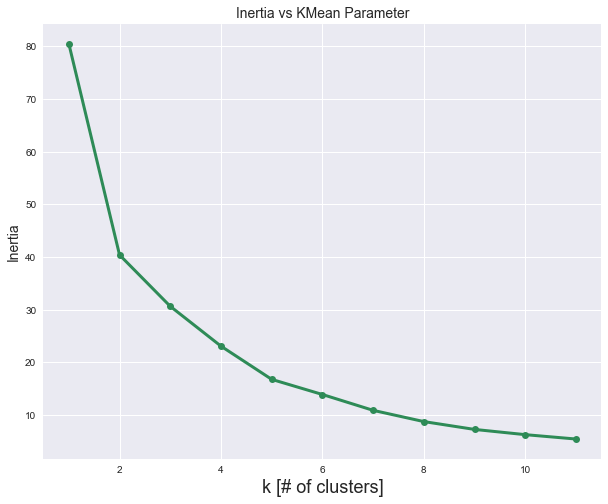

In [99]:
figInertiaWithK = plt.figure(figsize=(10,8))

plt.plot(kRange, KmeanTopics, 'o-', color='seagreen', linewidth=3)
plt.xlabel('k [# of clusters]', size=18)
plt.ylabel('Inertia', size=14)
plt.title('Inertia vs KMean Parameter', size=14)

In [114]:
list(Tfeatures.columns.values) + features

['T1',
 'T2',
 'T3',
 'T4',
 'tClusters',
 'danceability',
 'energy',
 'acousticness',
 'valence',
 'pitch_med',
 'timbre_med']

In [116]:
cols = list(songsDF.columns.values) + list(Tfeatures.columns.values) 
cols

['level_0',
 'index',
 'artist_id',
 'tags',
 'track_id',
 'title',
 'song_id',
 'release',
 'artist_mbid',
 'artist_name',
 'duration',
 'artist_familiarity',
 'artist_hotttnesss',
 'year',
 'track_7digitalid',
 'shs_perf',
 'shs_work',
 'lyrics_text',
 'spotifyURI',
 'songFeatures',
 'language',
 'lyrics_clean',
 'FKRG1',
 'fkrg_sent1',
 'FKRG2',
 'fkrg_sent2',
 'bar_len',
 'beat_len',
 'seg_len',
 'pitch_mean',
 'pitch_med',
 'timbre_mean',
 'timbre_med',
 'drop_row',
 'genre',
 'country_cnt',
 'pop_cnt',
 'other_cnt',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'type',
 'id',
 'uri',
 'track_href',
 'analysis_url',
 'duration_ms',
 'time_signature',
 'K_cluster_n3',
 'pca1',
 'pca2',
 'pca3',
 'K_cluster_n2',
 'T1',
 'T2',
 'T3',
 'T4',
 'tClusters']

In [124]:
analyzedDF = pd.DataFrame(data=None, columns=cols)


In [122]:
analyzedDF

,level_0,index,artist_id,tags,track_id,title,song_id,release,artist_mbid,artist_name,...,K_cluster_n3,pca1,pca2,pca3,K_cluster_n2,T1,T2,T3,T4,tClusters


In [123]:
print(len(songsDF), len(Tfeatures))

5881 5881


In [125]:
analyzedDF = pd.concat([songsDF, Tfeatures], axis=1)

In [129]:
artists = ['Keith Urban', 'Jennifer Lopez', 'Katy Perry', 'Lady Antebellum']

In [138]:
analyzedDF[analyzedDF.tClusters == 0][['artist_name', 'title','K_cluster_n3', 'K_cluster_n2', 'T1','T2','T3','T4','tClusters']]

,artist_name,title,K_cluster_n3,K_cluster_n2,T1,T2,T3,T4,tClusters
0,Tiffany Evans,Can't Walk Away,1,0,0.039729,0.880925,0.039660,0.039686,0
2,Tiffany Evans,Thinkin About,1,0,0.031329,0.906035,0.031321,0.031315,0
3,Tiffany Evans,Again,0,0,0.031511,0.905471,0.031515,0.031503,0
5,Tiffany Evans,Angels on Earth,1,0,0.038215,0.885360,0.038221,0.038205,0
7,Brooke Waggoner,Wish for Bridges,2,1,0.043465,0.869604,0.043466,0.043465,0
8,Brooke Waggoner,Body,2,1,0.029109,0.912643,0.029145,0.029104,0
10,Brooke Waggoner,Chromates Soft Love,2,1,0.046519,0.860451,0.046517,0.046513,0
11,Brooke Waggoner,Find Her Floods,2,1,0.037636,0.887097,0.037637,0.037630,0
12,Britney Spears,Toy Soldier,1,0,0.032526,0.903365,0.032049,0.032060,0
13,Britney Spears,Lonely,1,0,0.033460,0.899620,0.033460,0.033460,0


In [131]:
analyzedDF[analyzedDF.artist_name.isin(artists)][['artist_name', 'title','K_cluster_n3', 'K_cluster_n2', 'T1','T2','T3','T4','tClusters']]

,artist_name,title,K_cluster_n3,K_cluster_n2,T1,T2,T3,T4,tClusters
188,Katy Perry,Waking Up In Vegas,0,0,0.035929,0.892150,0.035921,0.035999,0
189,Katy Perry,Ur So Gay,1,0,0.079992,0.839034,0.040433,0.040542,0
190,Katy Perry,I'm Still Breathing,0,0,0.027999,0.916005,0.027999,0.027998,0
191,Katy Perry,Thinking Of You,0,0,0.031796,0.904043,0.032367,0.031794,0
192,Katy Perry,One Of The Boys,1,0,0.030986,0.906892,0.030989,0.031133,0
1769,Jennifer Lopez,(Can't Believe) This Is Me,1,0,0.031385,0.905847,0.031385,0.031384,0
1770,Jennifer Lopez,Loving You,1,0,0.035033,0.894899,0.035035,0.035033,0
1771,Jennifer Lopez,Never Gonna Give Up,1,0,0.039401,0.881799,0.039401,0.039400,0
1772,Jennifer Lopez,Be Mine,1,0,0.037327,0.888021,0.037329,0.037323,0
1773,Jennifer Lopez,I'm Gonna Be Alright,1,0,0.036556,0.890332,0.036556,0.036556,0


In [149]:
analyzedDF.artist_id.value_counts()

ARDBSFT1187B9AC9C1    48
AR6OSQ81187FB3FDAB    48
ARF3GX71187FB3EB66    47
AR9O6V81187FB3E38B    47
ARCLPC51187FB52F2D    40
AR5OB9M1187FB52F29    37
AR0IU4L1187FB4CCB9    36
ARFM0TP1187B9A0745    34
AR76NY61187FB4F82F    34
AREZWXB1187FB4958E    33
AR65K7A1187FB4DAA4    33
ARFWL8S1187B9B4B44    33
ARB33IT1187FB4ED69    33
AR03BDP1187FB5B324    32
AR4Q9XI1187FB40210    31
AR2JB471187FB470A2    31
ARD9UVF1187B9B17FE    31
AR7QE9M1187B9B07C1    31
AR0VAZ71187FB5AAD6    31
ARFL8LM1187B989D0D    31
AR4FBUO1187B9B6072    31
AR5LDM21187B9AC3DE    30
AREHK7O1187B9ADDD7    30
AR0URB11187FB46C1C    30
AR95IYB1187FB3FE0B    30
AR3FYKL1187FB44945    30
AR2SG8E1187FB52CDD    29
ARCZD9J1187FB3BC5B    29
AR4DW2Q1187FB44DB6    28
AR3JMC51187B9AE49D    28
                      ..
AR1YDJM1187FB42A46     1
ARDQQIL126A031DF10     1
AR0PH3A1187B993467     1
AR65TIH1187B9B5EEF     1
AR7LVSR1187FB3E1F2     1
AR7W8OQ1187FB5A9FC     1
ARAC77E1187B993BE1     1
AR66KG01187B992458     1
AR223VB1187B9B1A52     1


In [150]:
analyzedDF.groupby('tClusters')['genre'].value_counts()

tClusters  genre  
0          country    2801
           pop        2505
1          pop          41
           country      32
2          pop         204
           country     202
3          country      48
           pop          48
Name: genre, dtype: int64

### Findings:

1) The cluster characteristics produced by the three different cluster methods were similar.  Main clusters can be described with the following features:

- lower energy, high acoustic, lowest valence, low timbre, low pitch
- high energy, low valence, high pitch, low acoustic
- High energy, high danceability, high valence, high timbre

2) With the audio features we were able to collect, none of these features could clearly distinguish a country song from a Pop song, although majority of Country songs are classified under the cluster with (lower energy, high acoustic, lowest valence, low timbre, low pitch), while majority of the Pop songs are classified under the cluster with (high energy, low valence, high pitch, low acoustic).

3) Looking at the scatter plots for the results of the different clustering methods, the results from KMeans appear to have more distinct clusters between the different features which were plotted out.  

4) Classification of songs between KMeans and Agglomerate Clustering with Linkage = 'complete appear to be more consistent, where majority of the country songs are classified under the cluster with features (High Acoustic, Low Energy, Low Timbre, Low Pitch, Low Valence), and majority of pop songs were classified under the cluster with features (High Energy, Low Acoustic, Low Danceability, Low Valence, High Pitch).  Whereas for Agglomerate clustering wih linkage = 'ward', even if the cluster features are the same, it classified the songs differently.  Majority of the songs were classified in the 'overlap' class -- with features: High Energy, High Danceability, High Valence, High Timbre.



### Next Steps:

Evaluate clusters...formulate conclusion.